In [265]:
import pyswarms as ps
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
from joblib import Parallel, delayed

from pyswarms.utils.plotters import plot_cost_history

from data_preprocessing import truck_df, get_combined_df, distances_df

## This lab tries to solve the VRP using the PSO algorithm

### Distances visualization

In [2]:
distances_df.sample(5)

,Source,Destination,Distance(M)
824,City_35,City_32,1315170
876,City_48,City_41,788337
2428,City_29,City_49,686968
1403,City_41,City_24,1126494
343,City_19,City_29,1556847


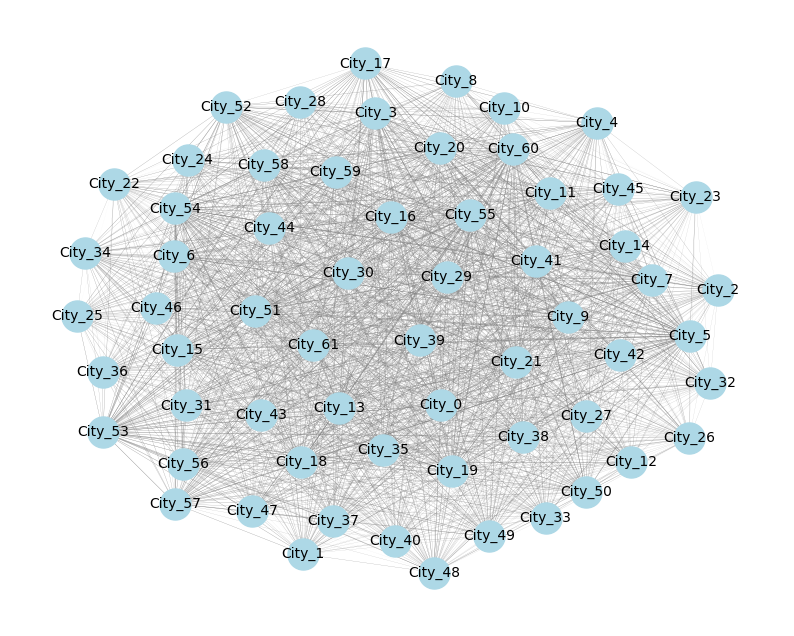

In [267]:
G = nx.from_pandas_edgelist(distances_df, source='Source', target='Destination', edge_attr='Distance(M)')

edge_widths = [d['Distance(M)'] / 10_000_000 for (u, v, d) in G.edges(data=True)]

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray')
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

plt.axis('off')
plt.show()

In [268]:
truck_df

,Truck Length,Inner Size (m^2),Weight Capacity (kg),Cost Per KM,Speed (km/h)
0,16.5,40.25,10000,3,40
1,12.5,30.25,5000,2,35
2,9.6,20.93,2000,1,30


In [269]:
combined_df = get_combined_df()
combined_df.sample(10)

d:\ХНУРЕ\оінт\src\computational_intelligence\lab4\data_preprocessing.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3.888 3.888 3.888 3.888 3.888 0.984 0.984 0.984 0.984 0.984]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  raw_df.loc[:, ['Area', 'Weight']] = raw_df.loc[:, ['Area', 'Weight']] / 10_000


,Order_ID,Material_ID,Item_ID,Source,Destination,Available_Time,Deadline,Danger_Type,Area,Weight,Distance(M)
4,A140112,B-6128,P01-7208eb61-2cc1-4e7c-b698-e1ab2327b658,City_61,City_54,1.649376e+09,1.649894e+09,type_1,3.888,3092,2444326
3,A140112,B-6128,P01-4534a7e8-6d73-4a2e-8363-a6645d9bc345,City_61,City_54,1.649376e+09,1.649894e+09,type_1,3.888,3092,2444326
7,A190226,B-6155,nan-c9658637-b5f1-433d-885e-b3008612a73d,City_61,City_53,1.649376e+09,1.649894e+09,type_2,0.984,764,2458223
8,A190226,B-6155,nan-75768ff3-3dde-4952-9aa0-594c373421d1,City_61,City_53,1.649376e+09,1.649894e+09,type_2,0.984,764,2458223
6,A190225,B-6155,nan-5ae70ea9-a28e-4107-b267-5a6c84d4a3c7,City_61,City_53,1.649203e+09,1.649722e+09,type_2,0.984,764,2458223
9,A190226,B-6155,nan-39cdd29b-baee-4ed6-bec0-33227cc8608d,City_61,City_53,1.649376e+09,1.649894e+09,type_2,0.984,764,2458223
2,A140112,B-6128,P01-b70c94db-630a-497b-bb63-b0ad86a7dce6,City_61,City_54,1.649376e+09,1.649894e+09,type_1,3.888,3092,2444326
0,A140109,B-6128,P01-79c46a02-e12f-41c4-9ec9-25e48597ebfe,City_61,City_54,1.649203e+09,1.649722e+09,type_1,3.888,3092,2444326
5,A190223,B-6155,nan-4ac2f30e-bc0a-4415-8612-a6b38d833317,City_61,City_53,1.649290e+09,1.649808e+09,type_2,0.984,764,2458223
1,A140112,B-6128,P01-84ac394c-9f34-48e7-bd15-76f92120b624,City_61,City_54,1.649376e+09,1.649894e+09,type_1,3.888,3092,2444326


### Modeling the problem in terms of PSO

1. Solution format: let's say N trucks can be used and planning is done for T time slots in advance, all the actions are performed heuristically, then the solution can be represented as a schedule for the trucks
2. Optimization target is the cost: there is a payment for each successful delivery and fee (based on a payment) for each incomplete or delayed delivery, payment is based on the weight of the item. Driving also costs money and is balanced to be adequate.

In [270]:
N = 10
T = 24
D_T = 4 * 3600 
FEE = 0.5
GAS_PRICE = 1

distances = np.zeros([62, 62])
def index_lookup(city):
    return int(city[5:])

for row in distances_df.iterrows():
    row = row[1]
    distances[index_lookup(row["Source"]), index_lookup(row["Destination"])] = row["Distance(M)"] / 1000

def distance(start, end):
    return distances[start][end]
        

In [271]:
def evaluate(x, verbose=False):
    total_movements_cost = 0

    # split the x into N parts of size T
    trucks = np.split(x, N)

    # Copy combined df for orders
    available_orders = combined_df.copy().sort_values('Weight', ascending=False)
    pending_orders = combined_df.copy()
    finished_in_time_orders = []
    finished_late_orders = []

    for truck_schedule in trucks:
        truck_type, *schedule = truck_schedule.astype(int).tolist()
        movements_cost = 0
        
        # initialize the truck based on the type
        truck = []
        # item_type = None
        truck_max_space = truck_df.loc[truck_type]["Inner Size (m^2)"]
        truck_max_weight = truck_df.loc[truck_type]["Weight Capacity (kg)"]
        truck_consumption = truck_df.loc[truck_type]["Cost Per KM"]
        truck_speed = truck_df.loc[truck_type]["Speed (km/h)"]

        if verbose:
            print(f"Truck type: {truck_type}")
            print(truck_df.loc[truck_type])

        time = combined_df["Available_Time"].min() # Start at the earliest available time
        current_city = schedule[0]

        for destination in schedule:
            # add the cost of driving from current position to the destination
            d = distance(current_city, destination)
            movement_cost = truck_consumption * d / 1000 * GAS_PRICE
            movements_cost += movement_cost
            time += int(d / 1000 / truck_speed * 3600)
            current_city = destination

            if verbose:
                print(f"Truck arrives at City_{current_city} spending {movement_cost} Timestamp: {time}")

            # unload if possible
            #   extract all the items that match the current_city
            #   add those matching the deadline to finished orders
            pending_orders_at_city = pending_orders[pending_orders["Destination"]==f"City_{current_city}"]
            for item in truck:
                if item not in pending_orders_at_city["Item_ID"].values:
                    continue

                if verbose:
                    print(f"Truck unloads {item}")

                truck.remove(item)
                order_index = pending_orders.index[pending_orders["Item_ID"] == item][0]

                if time <= pending_orders.loc[order_index]["Deadline"]:
                    if verbose:
                        print(f"Truck unloads in time")
                    finished_in_time_orders.append(item)
                else:
                    if verbose:
                        print(f"Truck unloads late")
                    finished_late_orders.append(item)
                
                pending_orders = pending_orders.drop([order_index])

            # load greedily: 
            #   get all the items available within the time slot (from current time to stay duration)
            #   while there are fitting items (match the weight and the space) place in the truck
            available_orders_at_city = available_orders[available_orders["Source"]==f"City_{current_city}"]
            available_orders_at_city = available_orders_at_city[available_orders_at_city["Available_Time"] <= (time + D_T)]

            can_fit_items = True
            free_space = truck_max_space - combined_df[combined_df["Item_ID"].isin(truck)]["Area"].sum()
            free_weight = truck_max_weight - combined_df[combined_df["Item_ID"].isin(truck)]["Weight"].sum()
            while can_fit_items:                    
                available_orders_at_city = available_orders_at_city[available_orders_at_city["Weight"] <= free_weight]
                available_orders_at_city = available_orders_at_city[available_orders_at_city["Area"] <= free_space]

                if len(available_orders_at_city) == 0:
                    can_fit_items = False
                    break
                else:
                    order = available_orders_at_city.iloc[0]
                    truck.append(order["Item_ID"])
                    
                    if verbose:
                        print(f"Truck loads {order['Item_ID']}")

                    free_weight -= order["Weight"]
                    free_space -= order["Area"]
                    
                    available_orders = available_orders.drop(order.name)
                    available_orders_at_city = available_orders_at_city.drop(order.name)

            time += D_T
        
        total_movements_cost += movements_cost
        if verbose:
            print(f"Total spent on gas: {movements_cost}")

    finished_in_time_orders_index = combined_df["Item_ID"].isin(finished_in_time_orders)
    finished_late_orders_index = combined_df["Item_ID"].isin(finished_late_orders)

    # add the payout for finished deliveries
    payout = combined_df[finished_in_time_orders_index]["Weight"].sum()
    # add the fees for failed deliveries
    fee = combined_df[~(finished_in_time_orders_index | finished_late_orders_index)]["Weight"].sum() * FEE
    
    total_cost = total_movements_cost + fee - payout

    if verbose:
        print(f"Movements cost: {total_movements_cost} Payout: {payout} Fee: {fee} Total: {total_cost}")

    return total_cost

In [272]:
# Absolutely random initial pos converges pretty slowly, so heuristic is used:
# 1. The biggest truck is used
# 2. Trucks start at known sources looped 

def generate_initial_pos(n_particles):
    sources = combined_df["Source"].to_list()
    random.shuffle(sources)
    sources_bag = itertools.cycle(sources)
    
    def generate_schedule():
        return [0] + [int(sources_bag.__next__()[5:])] + [random.randint(0, 61) for _ in range(T - 1)]
 
    def generate_particle():
        return list(itertools.chain(*[generate_schedule() for _ in range(N)]))

    return np.array([generate_particle() for _ in range(n_particles)], dtype=int) 

In [274]:
def get_chunks(bounds):
    return list(map(lambda i: len(np.binary_repr(i)), bounds))

def discrete_to_binary(ints, chunks):
    bits = list(map(lambda i, w: list(map(int, np.binary_repr(i, width=w))), ints, chunks))
    return np.array(list(itertools.chain(*bits)))

def bits_to_int(bits):
    return bits @ 2**np.arange(bits.shape[0])[::-1]

def binary_to_discrete(bits, chunks, min_bounds, max_bounds):
    offset = 0
    bit_arrays = []

    for chunk in chunks:
        bit_arrays.append(bits[offset:offset+chunk])
        offset += chunk
    
    discrete = np.array(list(map(bits_to_int, bit_arrays)))
    return np.clip(discrete, min_bounds, max_bounds)

In [275]:
dimensions = N * (T + 1)
schedule_max_bound = [2] + [61] * T
bounds = (np.zeros(dimensions), np.array(schedule_max_bound * N))
n_particles=100

chunks = get_chunks(bounds[1])
dimensions_bin = sum(chunks)

def objective_function(x):
    costs = Parallel(4)(delayed(evaluate)(binary_to_discrete(x[i], chunks, bounds[0], bounds[1])) for i in range(x.shape[0]))    
    return np.array(costs)

initial_positions = generate_initial_pos(n_particles)
initial_positions_bin = np.array([discrete_to_binary(initial_positions[i].tolist(), chunks) for i in range(n_particles)])

optimizer = ps.discrete.BinaryPSO(
    n_particles=n_particles,
    dimensions=dimensions_bin,
    options={'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3,'p': 2},
    init_pos=initial_positions_bin
)

best_cost, best_solution = optimizer.optimize(objective_function, iters=100)

2024-12-17 15:02:46,591 - pyswarms.discrete.binary - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|100/100, best_cost=-1.31e+4
2024-12-17 15:25:07,883 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: -13061.930013000001, best pos: [0 0 0 ... 0 1 1]


In [276]:
evaluate(binary_to_discrete(best_solution, chunks, bounds[0], bounds[1]), verbose=True)

Truck type: 0
Truck Length               16.50
Inner Size (m^2)           40.25
Weight Capacity (kg)    10000.00
Cost Per KM                 3.00
Speed (km/h)               40.00
Name: 0, dtype: float64
Truck arrives at City_11 spending 0.0 Timestamp: 1649203199.0
Truck arrives at City_47 spending 4.08615 Timestamp: 1649217721.0
Truck arrives at City_16 spending 1.9283760000000003 Timestamp: 1649232178.0
Truck arrives at City_12 spending 5.316615 Timestamp: 1649246737.0
Truck arrives at City_16 spending 5.306127 Timestamp: 1649261296.0
Truck arrives at City_50 spending 3.188535 Timestamp: 1649275791.0
Truck arrives at City_13 spending 5.347296 Timestamp: 1649290351.0
Truck arrives at City_12 spending 1.280049 Timestamp: 1649304789.0
Truck arrives at City_35 spending 1.046484 Timestamp: 1649319220.0
Truck arrives at City_30 spending 2.8335839999999997 Timestamp: 1649333705.0
Truck arrives at City_19 spending 4.761177 Timestamp: 1649348247.0
Truck arrives at City_23 spending 4.3776179999

-13061.930013000001

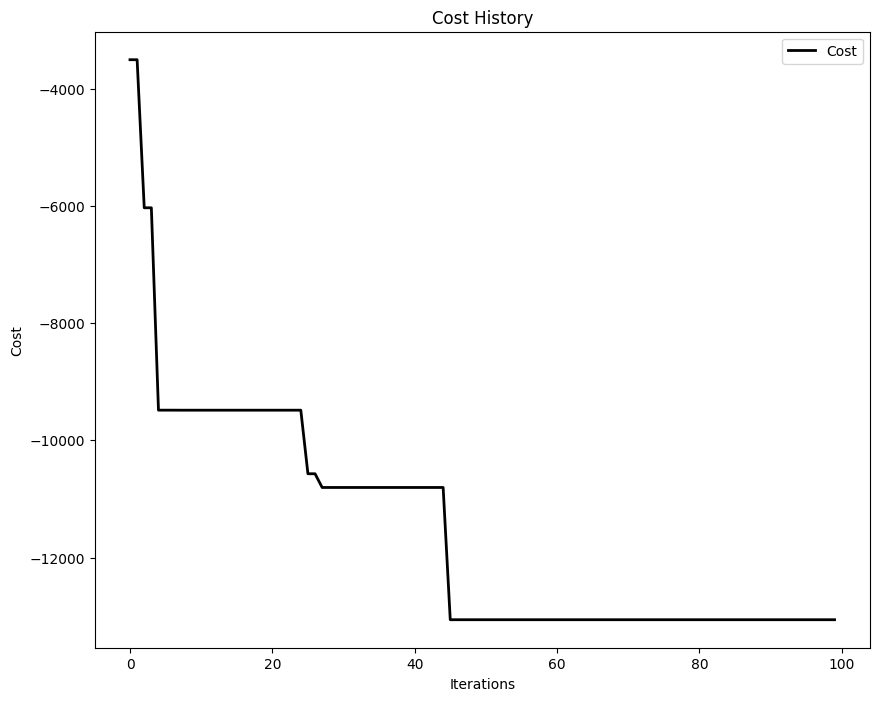

In [277]:
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()